Working Directory to: /home/qy2672/learning-alternations


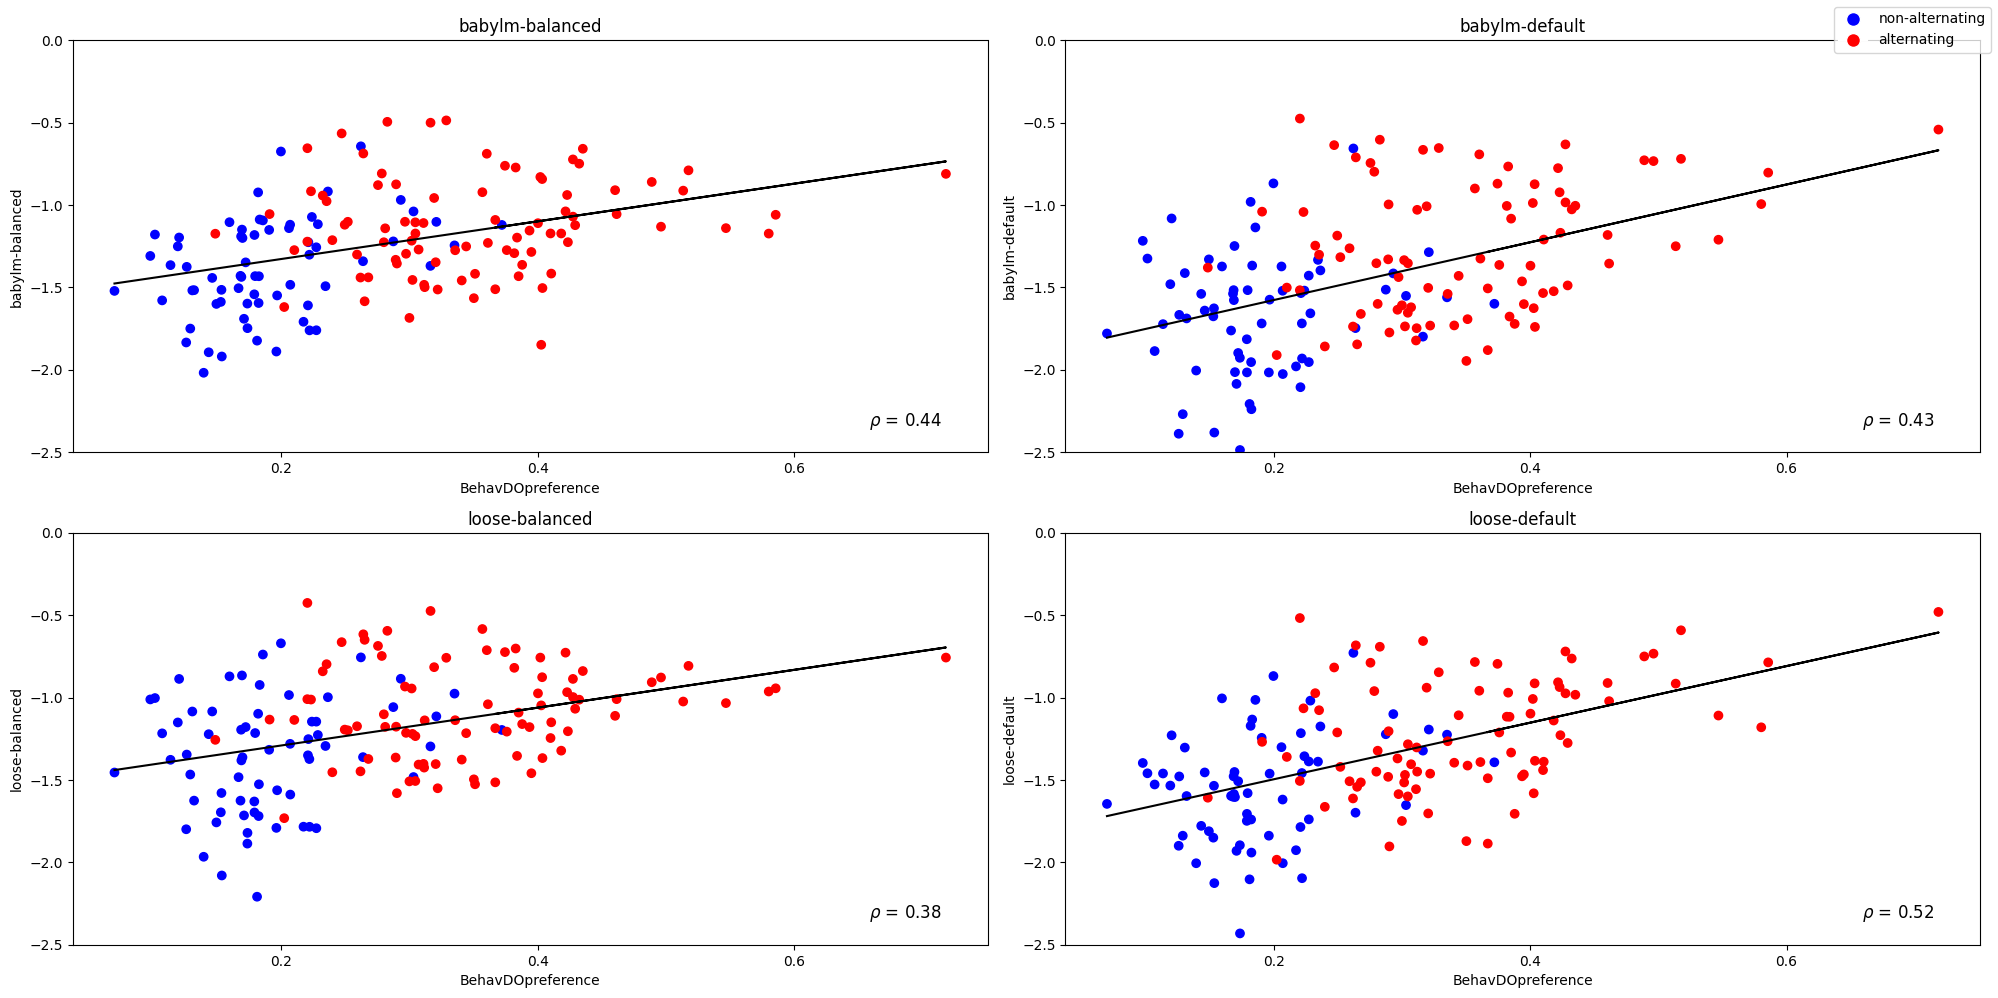

In [4]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import os

os.chdir('/home/qy2672/learning-alternations')
print("Working Directory to:", os.getcwd())
df = pd.read_csv('experiments/generated_pairs_with_results.csv')

df = df[df['verb_count'] >= 1]

avg_across_verbs = df.groupby('verb_id')[['bert_ratio', 'BehavDOpreference', 'ngram_ratio', 'lstm_ratio', 'gpt2_ratio', 'gpt2-large_ratio', 'lstm-large_ratio', 'babylm-balanced_ratio', 'babylm-default_ratio', 'loose-balanced_ratio', 'loose-default_ratio']].mean().reset_index()

spearmans = [stats.spearmanr(avg_across_verbs['BehavDOpreference'], avg_across_verbs['gpt2-large_ratio']),
    stats.spearmanr(avg_across_verbs['BehavDOpreference'], avg_across_verbs['gpt2_ratio']),
    stats.spearmanr(avg_across_verbs['BehavDOpreference'], avg_across_verbs['bert_ratio']),
    stats.spearmanr(avg_across_verbs['BehavDOpreference'], avg_across_verbs['lstm-large_ratio']),
    stats.spearmanr(avg_across_verbs['BehavDOpreference'], avg_across_verbs['lstm_ratio']),
    stats.spearmanr(avg_across_verbs['BehavDOpreference'], avg_across_verbs['ngram_ratio']),
    stats.spearmanr(avg_across_verbs['BehavDOpreference'], avg_across_verbs['babylm-balanced_ratio']),
    stats.spearmanr(avg_across_verbs['BehavDOpreference'], avg_across_verbs['babylm-default_ratio']),
    stats.spearmanr(avg_across_verbs['BehavDOpreference'], avg_across_verbs['loose-balanced_ratio']),
    stats.spearmanr(avg_across_verbs['BehavDOpreference'], avg_across_verbs['loose-default_ratio'])
]

import matplotlib.pyplot as plt

ratios = ['gpt2-large_ratio', 'gpt2_ratio', 'bert_ratio', 'lstm-large_ratio', 'lstm_ratio', 'ngram_ratio', 'babylm-balanced_ratio', 'babylm-default_ratio', 'loose-balanced_ratio', 'loose-default_ratio']
x = avg_across_verbs['BehavDOpreference']
x = x/100

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
axes = axes.flatten()

for i, ratio in enumerate(ratios):
    if i < 6:
        continue
    y = avg_across_verbs[ratio]
    colors = ['blue' if verb_id <= 100 else 'red' for verb_id in avg_across_verbs['verb_id']]
    axes[i-6].scatter(x, y, c=colors, label=['non-alternating' if verb_id <= 100 else 'alternating' for verb_id in avg_across_verbs['verb_id']])
    axes[i-6].set_title(ratio.replace('_ratio', ''))
    axes[i-6].set_xlabel('BehavDOpreference')
    axes[i-6].set_ylabel(ratio.replace('_ratio', ''))
    axes[i-6].set_xticks([0.2, 0.4, 0.6])
    axes[i-6].set_ylim(-2.5, 0)

    # Calculate and plot the best fit line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    best_fit_line = slope * x + intercept
    axes[i-6].plot(x, best_fit_line, color='black')
    axes[i-6].text(0.95, 0.05, r"$\rho$" + f' = {spearmans[i][0]:.2f}', 
                 verticalalignment='bottom', horizontalalignment='right', 
                 transform=axes[i-6].transAxes, color='black', fontsize=12)

# Create a legend for the colors
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='non-alternating'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='alternating')]
fig.legend(handles=handles, loc='upper right')

plt.tight_layout()
plt.savefig('experiments/behavdopreference_vs_ratios.png', dpi=300)
plt.show()

In [5]:
#write scores into test sets
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from minicons import scorer
import os
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.chdir('/home/qy2672/learning-alternations')

def safe_score_sequence(text, lm, tokenizer):
    try:
        device = next(lm.model.parameters()).device
        
        inputs = tokenizer(
            text,
            return_tensors='pt',
            truncation=True,
            max_length=256,
            padding=True
        ).to(device)  

        return lm.sequence_score(inputs)[0]
    except Exception as e:
        print(f"Error processing text: {text}")
        print(f"Error: {str(e)}")
        return float('nan')
    
models = ['babylm-default', 'babylm-balanced', 'loose-default', 'loose-balanced']
hawkins = pd.read_csv('experiments/generated_pairs_with_results.csv')

for model_name in models:
    model_path = 'qing-yao/'+model_name+'_seed-42_1e-3'

    tokenizer = AutoTokenizer.from_pretrained(model_path)

    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype=torch.float32,
        device_map="auto"
    )

    lm = scorer.IncrementalLMScorer(
        model=model,
        device="auto",
        tokenizer=tokenizer
    )
    hawkins['do' + model_name] = hawkins['DOsentence'].apply(lambda x: safe_score_sequence(x, lm, tokenizer))
    hawkins['po' + model_name] = hawkins['PDsentence'].apply(lambda x: safe_score_sequence(x, lm, tokenizer))
    hawkins[model_name + '_ratio'] = hawkins['do'+model_name] - hawkins['po'+model_name]
    hawkins.drop(columns=['do'+model_name, 'po'+model_name], inplace=True)
    hawkins.to_csv('experiments/generated_pairs_with_results.csv', index = False)
    

KeyboardInterrupt: 

Working Directory to: /home/qy2672/learning-alternations


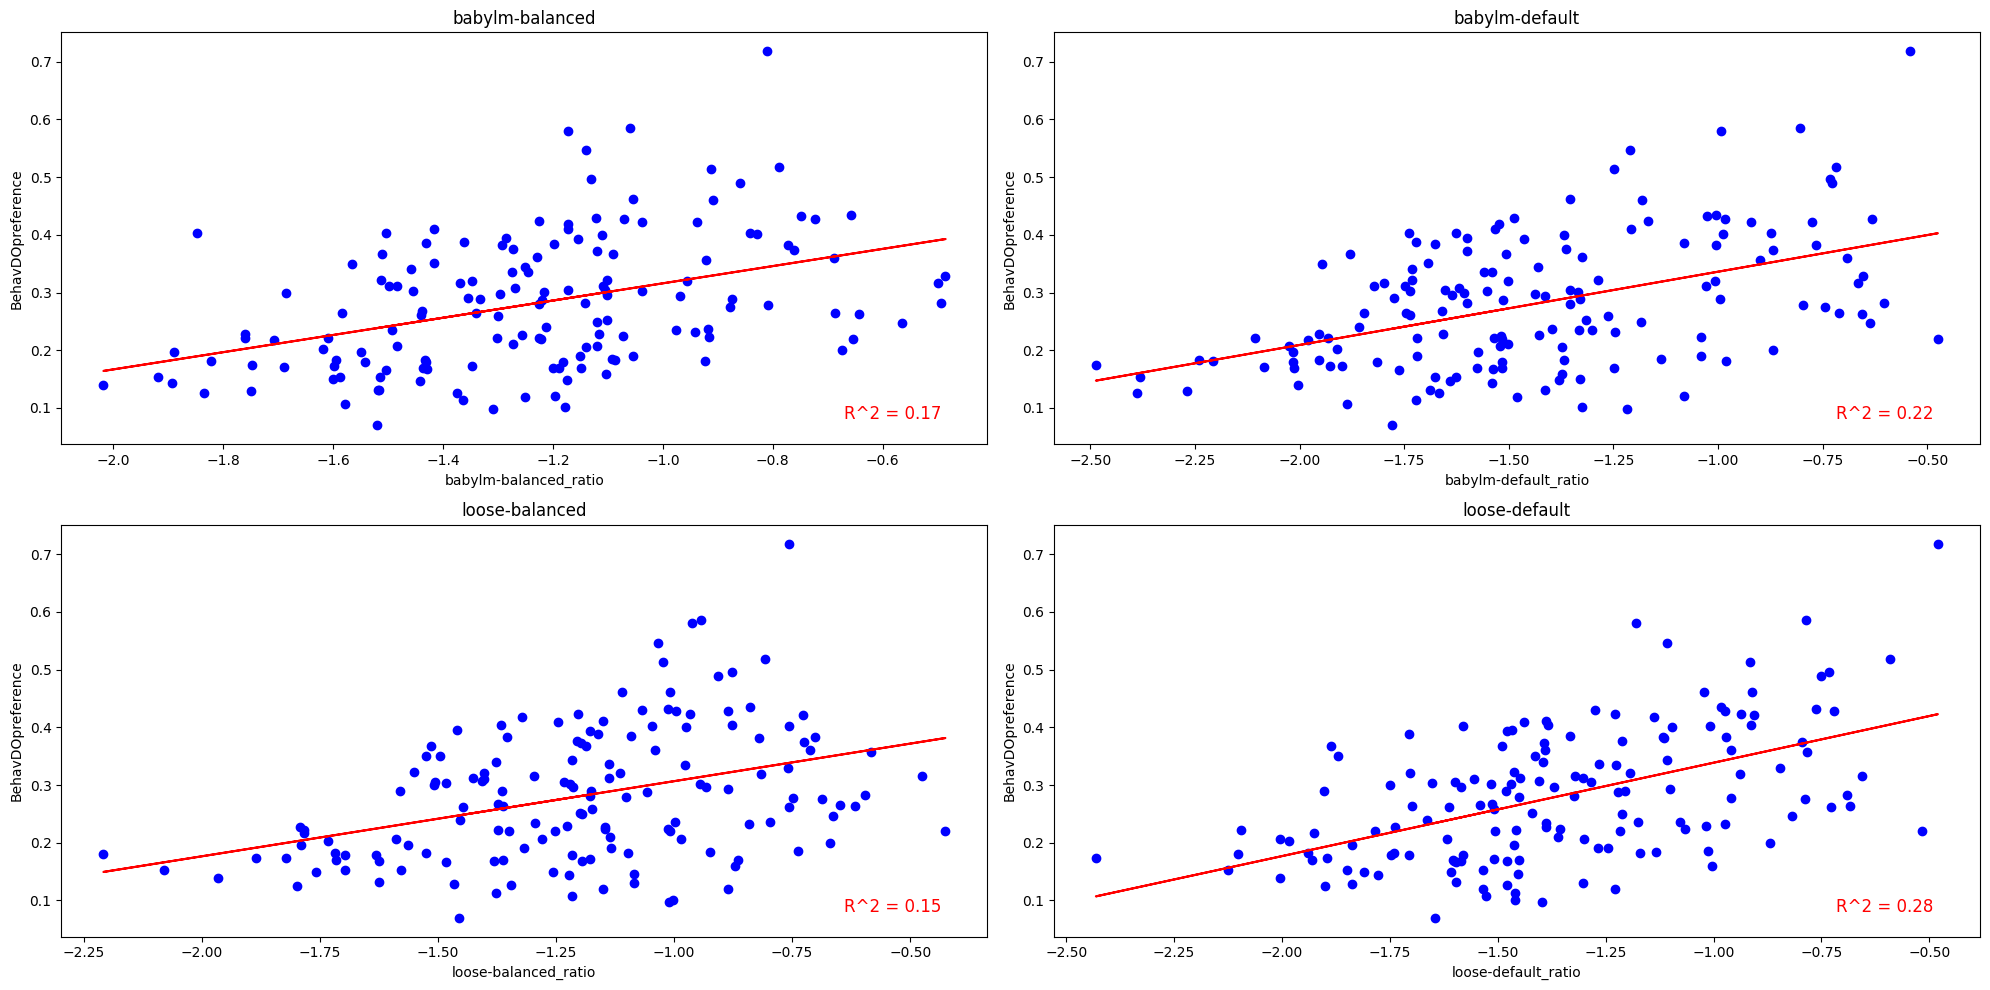

In [6]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import os

os.chdir('/home/qy2672/learning-alternations')
print("Working Directory to:", os.getcwd())
df = pd.read_csv('experiments/generated_pairs_with_results.csv')

df = df[df['verb_count'] >= 1]
df['BehavDOpreference'] = df['BehavDOpreference']/100
df = df.groupby('verb_id')[['bert_ratio', 'BehavDOpreference', 'ngram_ratio', 'lstm_ratio', 'gpt2_ratio', 'gpt2-large_ratio', 'lstm-large_ratio', 'babylm-balanced_ratio', 'babylm-default_ratio', 'loose-balanced_ratio', 'loose-default_ratio']].mean().reset_index()

models = ['babylm-balanced_ratio', 'babylm-default_ratio', 'loose-balanced_ratio', 'loose-default_ratio']
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
axes = axes.flatten()

for i, model in enumerate(models):
    x = df[model]
    y = df['BehavDOpreference']
    axes[i].scatter(x, y, color='blue')
    axes[i].set_title(model.replace('_ratio', ''))
    axes[i].set_xlabel(model)
    axes[i].set_ylabel('BehavDOpreference')

    # Calculate and plot the best fit line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    best_fit_line = slope * x + intercept
    axes[i].plot(x, best_fit_line, color='red')
    axes[i].text(0.95, 0.05, f'R^2 = {r_value**2:.2f}', 
                    verticalalignment='bottom', horizontalalignment='right', 
                    transform=axes[i].transAxes, color='red', fontsize=12)

plt.tight_layout()
plt.show()